# Goal
Principal component analysis for different taxonomic levels

# Libraries

In [2]:
library(microbiome)
library(dplyr)
library(phyloseq)
library(ggplot2)
library(plyr)
library(zCompositions)
library(compositions)
library(textshape)
library(tibble)
library(gcookbook)
library(tidyverse)

# Load

In [9]:
load("psq3.RData")
load("filt_psq.RData")
load('phyloseq-psor-control-metagenome.RData')

In [11]:
id_diagnosis<-sample_data(psq)[,c('ID','Diagnosis')]

psor_id <- c(id_diagnosis[id_diagnosis$Diagnosis=='psoriasis',1])$ID

# Analysis

In [33]:
make_pca <- function(psq, tax_rank) {
    psq_rank <- aggregate_taxa(psq, level = tax_rank)
    
    # STEP 1:
    # replace 0 values with the count zero multiplicative method
    # this function expects the samples to be in rows
    otu_rank_CZM <- t(cmultRepl(t(otu_table(psq_rank)), method="CZM", output="p-counts"))
    
    # CONVERT to PROPORTIONS by sample (columns) using the apply function
    otu_rank_CZM_prop <- apply(otu_rank_CZM, 2, function(x){x/sum(x)})
    
    # STEP 2: CLR Transformation:
    clr_rank <- t(apply(otu_rank_CZM_prop, 2, function(x){log(x) - mean(log(x))}))

    # NOTE: sample_id order will be identical at aggregated phyloseq objects

    # 1) take the transformed abundance table, 
    # 2) extract row-names, i.e. sample ids:
    # 3) find matching ids for psoriasis patients, assign 'green4' if match OR 'red' if not - controls

    mycols=data.frame(c(ifelse(rownames(clr_rank) %in% psor_id,'red','green4')))

    colnames(mycols) <- "colors"

    # Singular value decompositon: PCA 
    pcx_rank <- prcomp(clr_rank)

    # Sum the total variance
    d.mvar <- sum(pcx_rank$sdev^2)

    # modify donor IDS - rownames - make shorter to look nice on the plot:
    row.names(pcx_rank$x) <- gsub("_profile","", row.names(pcx_rank$x))
    output <- list(pcx_rank, mycols, d.mvar)

    return(output)
}

In [34]:
plot_biplot <- function(pcx, mycols, d.mvar) {
    # make a covariance biplot of the data with compositions function
    # BIG PLOT

    coloredBiplot(pcx, col="grey66", cex=c(0.6, 0.5), xlabs.col=mycols$colors,
              arrow.len=0.05,
              xlab=paste("PC1: ", round(sum(pcx$sdev[1]^2)/d.mvar, 3)),
              ylab=paste("PC2: ", round(sum(pcx$sdev[2]^2)/d.mvar, 3)),
              expand=0.8,var.axes=T, scale=1, main="Biplot")
}

In [ ]:
plot_biplot_wo_sp <- function(pcx, mycols, d.mvar) {
    # make a covariance biplot of the data with compositions function
    # BIG PLOT

    coloredBiplot(pcx_phylum, col="#ffffff00", cex=c(0.6, 0.5), xlabs.col=mycols$colors,
              var.axes=F,
              xlab=paste("PC1: ", round(sum(pcx_phylum$sdev[1]^2)/d.mvar, 3)),
              ylab=paste("PC2: ", round(sum(pcx_phylum$sdev[2]^2)/d.mvar, 3)),
              expand=0.8, scale=1, main="Biplot")
}

## Phylum

In [35]:
phylum <- make_pca(psq1, "Phylum")

Warning message in cmultRepl(t(otu_table(psq_rank)), method = "CZM", output = "p-counts"):
"Column no. 4 containing >80% zeros/unobserved values deleted (see arguments z.warning and z.delete).
Column no. 8 containing >80% zeros/unobserved values deleted (see arguments z.warning and z.delete).
Column no. 10 containing >80% zeros/unobserved values deleted (see arguments z.warning and z.delete).
Column no. 11 containing >80% zeros/unobserved values deleted (see arguments z.warning and z.delete).
"


In [36]:
pcx_phylum <- phylum[[1]]
mycols_phylum <- phylum[[2]]
d.mvar_phylum <- phylum[[3]]

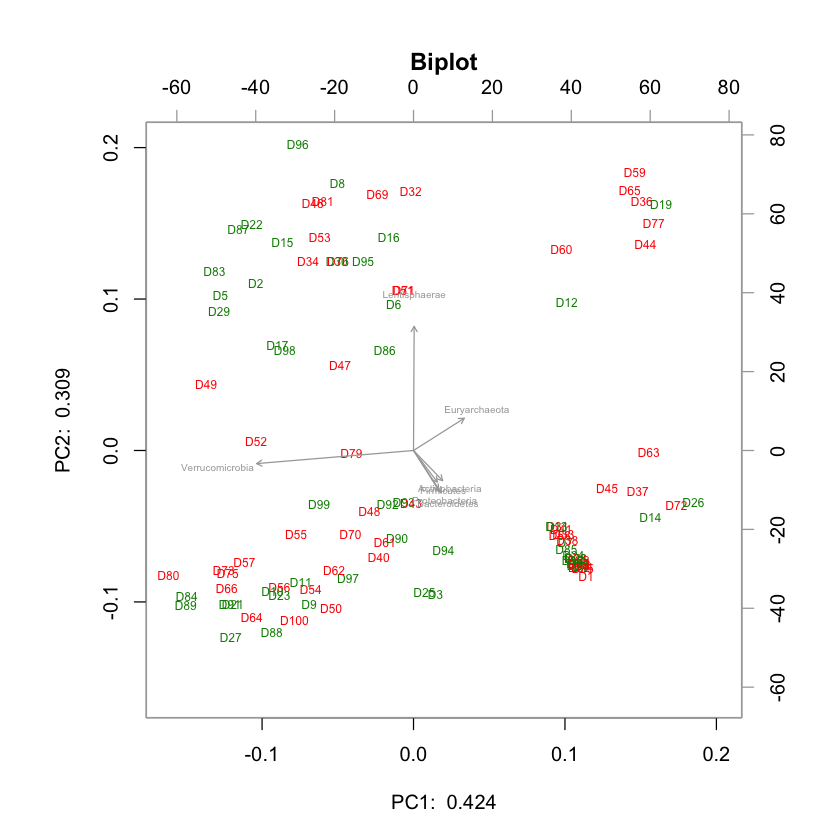

In [38]:
plot_biplot(pcx_phylum, mycols_phylum, d.mvar_phylum)